# Statistics Without Borders - Covid 19 Twitter Analysis
##### Author: Heli Vora
##### Date: 5/23/2020


# Part 1

The client provided a list of important terms/hashtags that could be used label the tweets as irrelevant and relevant. I followed two approaches here:
1. Using Regular Expressions/conditional statements to filter out relevant tweets according to the list provided by the client
2. Using unsupervised algorithm to cluster similar tweets together


## 1.Data Collection

My initial focus was to support the overall data collection effort. I focused on collecting the data for the month of March. I used the Robotic Process Automation tool UIpath in doing so. Since I have a licensed UIpath tool, it offered a premium connector. Once I enter the tweet criteria - such as location, terms we are looking for etc., the bot will scrape all the required data. At first, I put a criteria based on the hashtags the client provided. However, this criteria resulted in only about 80 tweets for Palo Alto in the month of March. This was happening because the bot was trying to look for exact matches of the client hashtag list. I realized that there would be a lot more tweets that could be speaking about the topic without using the exact list of words. Hence, I modified my approach and pulled all tweets for Palo Alto without for the month of March without any additional criteria. This resulted in about ~140K tweets.


In [1]:
#### Will load all the necessary libraries here
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#### Loading the March 2020 Twitter File
March2020 = pd.read_csv("MasterFile.csv",encoding = 'utf-8')
March2020.head(5)

C:\Users\VoraH\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Device,Ext URL,FullText,HashTags,Location,Retweet,TimeStamp,TweetID,isQuote
0,0,"<a href=""http://twitter.com/download/android"" ...",[],@VPrasadMDMPH The twitter account associated w...,[],"Palo Alto, CA",False,Tue Apr 21 01:41:05 +0000 2020,1.252412e+18,False
1,1,"<a href=""http://twitter.com/download/iphone"" r...","[{'url': 'https://t.co/r8Dok3PtnW', 'expanded_...",Cytokine release syndrome in severe COVID-19 |...,[],"Palo Alto, CA",False,Mon Apr 20 18:37:38 +0000 2020,1.252305e+18,False
2,2,"<a href=""http://twitter.com/download/android"" ...","[{'url': 'https://t.co/tlxzOinpub', 'expanded_...","#RonDeSantis hides ""crucial information"" about...",['RonDeSantis'],"Palo Alto, CA",False,Mon Apr 20 17:37:49 +0000 2020,1.252290e+18,False
3,3,"<a href=""http://twitter.com/download/iphone"" r...",[],@CAG_ID_Doc Great discussion about ARDS phenot...,[],"Palo Alto, CA",False,Mon Apr 20 17:17:12 +0000 2020,1.252285e+18,False
4,4,"<a href=""https://tapbots.com/software/tweetbot...","[{'url': 'https://t.co/B1eb13muVO', 'expanded_...",Super interesting ‘change in mobility’ dashboa...,[],"Palo Alto, CA",False,Mon Apr 20 15:22:58 +0000 2020,1.252256e+18,False


In [3]:
March2020 = March2020[['FullText']]

In [4]:
March2020.shape

(168626, 1)

## 2. Data Cleaning

We can observe that the Data has a lot of emojis, urls, slangs. We want to remove those or replace them.


In [5]:
###Remove all unrequired columns
#March2020.drop(['hashtags','date','City'],axis=1,inplace=True)
March2020.head(2)

,FullText
0,@VPrasadMDMPH The twitter account associated w...
1,Cytokine release syndrome in severe COVID-19 |...


In [6]:
###Remove duplicates and blanks
March2020.dropna(subset = ["FullText"], inplace=True)
March2020.drop_duplicates()
March2020.shape

(168625, 1)

In [7]:

nan_value = float("NaN")

March2020.replace("", nan_value, inplace=True)

March2020.dropna(subset = ["FullText"], inplace=True)

In [8]:
March2020.head(20)

March2020.replace(' ', nan_value, inplace=True)

March2020.dropna(subset = ["FullText"], inplace=True)

In [9]:
March2020.head(20)
March2020.shape

(168625, 1)

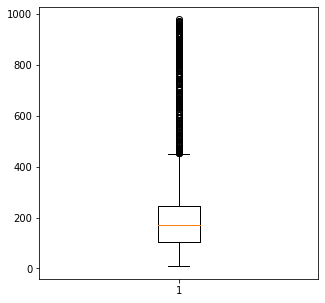

In [10]:
# Checking for the length of the tweets

March2020['pre_clean_len'] = [len(t) for t in March2020.FullText]
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(March2020.pre_clean_len)
plt.show()

The maximum length of a tweet is 280. However we can see in the box plot that there are various outliers where length of the tweets is upto 1000. This must be due to presence of urls, emojis, images etc. Let us clean them

In [11]:
March2020[March2020.pre_clean_len > 550].head(5)

,FullText,pre_clean_len
890,@psychmd1 @Lcars24 @bonitalea @joe_kidder2 @ag...,837
2092,@SproutSocial @jamiewo @heymsroti @hiyeshello ...,741
4527,@michellmybell1 @BeckyJohnson222 @SMcwoof @kfu...,879
4528,@michellmybell1 @BeckyJohnson222 @SMcwoof @kfu...,872
4537,@mcfunny @michellmybell1 @TakeThatCDC @crabb_v...,819


In [12]:
March2020 = March2020[March2020.pre_clean_len > 30]

In [13]:
March2020.shape

(167705, 2)

In [14]:
###Removing mentions, hashtages, emojis, urls

###Not removing Numbers to capture covid 19, percentage rate etcs


## Removing HTML encoding
import re
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    stripped = re.sub(combined_pat, '', text)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z0-9]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()


testing = March2020['FullText']

test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))
    


In [15]:
clean_df = pd.DataFrame(test_result,columns=['text'])
clean_df.head(20)

,text
0,the twitter account associated with that youtu...
1,cytokine release syndrome in severe covid 19 t...
2,rondesantis hides crucial information about co...
3,id doc great discussion about ards phenotypes ...
4,super interesting change in mobility dashboard...
5,trump and the gop are actually denying needed ...
6,far more covid 19 cases in silicon valley than...
7,we need tech more than ever but that doesn t m...
8,support clinical trials of peginterferon lambd...
9,sorry but his answer is not convincing it is a...


In [16]:


clean_df.replace(" ", nan_value, inplace=True)

clean_df.dropna(subset = ["text"], inplace=True)


In [17]:
clean_df.shape

(167705, 1)

## 3. Using Regex to filter out tweets

The client provided the dictionary/list of important hashtags/words

In [18]:
####Creating a dictionary based on tweets provided by the client

#### I have also added terms with spaces here i.e. if there is word handsanitizer, there is also a word hand sanitizer

#dict1 = ['actnowsavelives','ambulance','beready','clinicians','clinics','clorox','facemasks','handsanitizer','handwashing','medicine','ppe','publichealthisessential','quarantine','quarantined','stayhomeifyouresick','stayhealthy','washyourhands','washyourphone','infectioncontrol','stayhome','flattenthecurve','socialdistance','socialdistancing','stayhomesavelives','coronaviruspandemic','herdimmunity','staythefhome','selfquarantine','risks_symptoms','chronicillness','diamondprincess','epidemic','facetouchchallenge','flu','outbreak','pandemic','superspreaders','virusoutbreak','lungscans','ncip','ards','elderly','agedcare','agedcared','caregiving','eldercare','elderlaw','homecare','homenursing','nursinghome','senior','seniorcare','skillednursing','snf','socialcare','aging','nursinghomeoutbreak','sentiments','cdcfail','endthecoronavirus','factsnotfear','gowuhan','trumpnotfitforoffice','standwithwuhan','trumpvirus','wearethenewsnow','corruptgop','fightagainstcorona','weneedmoretests','wherearethetests','trumpviruscoverup','purge','testvirusnow','votebluenomatterwho2020','trumpisanidiot','pencedemic','complicitcorruptgop','solidarityat8','covidiot','inthistogether','miscellaneous','2019ncov','caronaviruses','caronavirusus','coronaoutbreak','coronavid19','coronavirus','corona','coronaviruschallenge','coronaalert','coronalegshake','coronavirusoutbreak','coronavirusfacts','coronavirusnews','coronavirustruth','coronavirusupdate','covid','covid_19','covid_19pandemic','covid - -19','covid19','covid19-19','covid2019','nationalcoronaviruspandemic','ncov','ncov_2019','ncov2019','novelcoronavirus','sars_cov_2','sars-cov-2','sarscov19','sarscov2','sarsvirus','coronavirusupdates']
dict1 = ['actnowsavelives','ambulance','beready','clinicians','clinics','clorox','facemasks','facecover','sanitizer','handsanitizer','handwashing','medicine','ppe','publichealthisessential','quarantine','quarantined','stayhomeifyouresick','stayhealthy','washyourhands','washyourphone','infectioncontrol','stayhome','flattenthecurve','socialdistance','socialdistancing','stayhomesavelives','coronaviruspandemic','herdimmunity','staythefhome','selfquarantine','risks_symptoms','chronicillness','diamondprincess','epidemic','facetouchchallenge','flu','outbreak','pandemic','superspreaders','virusoutbreak','lungscans','ncip','ards','elderly','agedcare','agedcared','caregiving','eldercare','elderlaw','homecare','homenursing','nursinghome','senior','seniorcare','skillednursing','snf','socialcare','aging','nursinghomeoutbreak','sentiments','cdcfail','endthecoronavirus','factsnotfear','gowuhan','trumpnotfitforoffice','standwithwuhan','trumpvirus','wearethenewsnow','corruptgop','fightagainstcorona','weneedmoretests','wherearethetests','trumpviruscoverup','purge','testvirusnow','votebluenomatterwho2020','trumpisanidiot','pencedemic','complicitcorruptgop','solidarityat8','covidiot','inthistogether','miscellaneous','2019ncov','caronaviruses','caronavirusus','coronaoutbreak','coronavid19','coronavirus','corona','coronaviruschallenge','coronaalert','coronalegshake','coronavirusoutbreak','coronavirusfacts','coronavirusnews','coronavirustruth','coronavirusupdate','covid','covid_19','covid_19pandemic','covid - -19','covid19','covid19-19','covid2019','nationalcoronaviruspandemic','ncov','ncov_2019','ncov2019','novelcoronavirus','sars_cov_2','sars-cov-2','sarscov19','sarscov2','sarsvirus','coronavirusupdates','symptoms','act now save lives','be ready','hand sanitizer','public health','wash your hands','wash my hands','wash hands','wash your phone','infection control','stay home','flatten the curve','social distance','social distancing','stay home save lives','coronavirus pandemic','herd immunity','immunity','self quarantine','risks symptoms','chronic illness','diamond princess','face touch challenge','super spreaders','virus outbreak','lung scans','aged care','aged cared','elder care','elder law','home care','home nursing','nursing home','senior care','skilled nursing','social care','nursing home outbreak','cdc fail','end the coronavirus','facts not fear','go wuhan','trump not fit for office','stand with wuhan','trump virus','we are the news now','corrupt gop','fight against corona','we need more tests','where are the tests','trump virus coverup','test virus now','test kits','testing','more tests','tests','vote blue no matter who 2020','trump is an idiot','complicit corrupt gop','solidarity at 8','in this together','corona outbreak','coronavid 19','corona virus challenge','corona alert','corona leg shake','corona virus outbreak','corona virus facts','corona virus news','corona virus truth','corona virus update','national corona virus pandemic','novel coronavirus','corona virus updates']  
# Converting 
lst = [x.upper() for x in dict1] 
  
# printing output 
print(lst) 

['ACTNOWSAVELIVES', 'AMBULANCE', 'BEREADY', 'CLINICIANS', 'CLINICS', 'CLOROX', 'FACEMASKS', 'FACECOVER', 'SANITIZER', 'HANDSANITIZER', 'HANDWASHING', 'MEDICINE', 'PPE', 'PUBLICHEALTHISESSENTIAL', 'QUARANTINE', 'QUARANTINED', 'STAYHOMEIFYOURESICK', 'STAYHEALTHY', 'WASHYOURHANDS', 'WASHYOURPHONE', 'INFECTIONCONTROL', 'STAYHOME', 'FLATTENTHECURVE', 'SOCIALDISTANCE', 'SOCIALDISTANCING', 'STAYHOMESAVELIVES', 'CORONAVIRUSPANDEMIC', 'HERDIMMUNITY', 'STAYTHEFHOME', 'SELFQUARANTINE', 'RISKS_SYMPTOMS', 'CHRONICILLNESS', 'DIAMONDPRINCESS', 'EPIDEMIC', 'FACETOUCHCHALLENGE', 'FLU', 'OUTBREAK', 'PANDEMIC', 'SUPERSPREADERS', 'VIRUSOUTBREAK', 'LUNGSCANS', 'NCIP', 'ARDS', 'ELDERLY', 'AGEDCARE', 'AGEDCARED', 'CAREGIVING', 'ELDERCARE', 'ELDERLAW', 'HOMECARE', 'HOMENURSING', 'NURSINGHOME', 'SENIOR', 'SENIORCARE', 'SKILLEDNURSING', 'SNF', 'SOCIALCARE', 'AGING', 'NURSINGHOMEOUTBREAK', 'SENTIMENTS', 'CDCFAIL', 'ENDTHECORONAVIRUS', 'FACTSNOTFEAR', 'GOWUHAN', 'TRUMPNOTFITFOROFFICE', 'STANDWITHWUHAN', 'TRUMPVIR

In [19]:
def text_manipulation(words_list, search_string):
    search_result = []
    for sentence in [words_list]:
        words = sentence.replace('.', '').replace(',', '').split(' ')
        [search_result.append(w) for w in words if w.upper() in search_string]
        return(search_result)

def find_keywords(df):
    distance_list = []
    for i in range(0, len(df)):
        d = text_manipulation(df.iloc[i]['text'] , lst)
        distance_list.append(d)
    return distance_list


clean_df['keywords'] = find_keywords(clean_df)
clean_df.head(20)

,text,keywords
0,the twitter account associated with that youtu...,[pandemic]
1,cytokine release syndrome in severe covid 19 t...,[covid]
2,rondesantis hides crucial information about co...,[covid]
3,id doc great discussion about ards phenotypes ...,"[ards, covid, covid]"
4,super interesting change in mobility dashboard...,[covid]
5,trump and the gop are actually denying needed ...,"[covid19, pandemic]"
6,far more covid 19 cases in silicon valley than...,"[covid, covid]"
7,we need tech more than ever but that doesn t m...,[covid]
8,support clinical trials of peginterferon lambd...,[covid]
9,sorry but his answer is not convincing it is a...,[pandemic]


I have created a new column Keywords, which captures the word from the client dictionary which are present in the tweet. The Keyword column contains the exact words that have been matched. I have used an exact match criteria here because otherwise it increased the number of false positives. Example: the word 'orchard' was flagged as the word 'ARD' is in the list to represent Acute Respiratory Disease.

As my next step, I filterd out tweets with no keywords to observe the no. of relevant tweets captured

In [20]:
clean_df['keywords'] = clean_df['keywords'].astype(str)
clean_df.head(20)
key_tweets = clean_df[clean_df.keywords != '[]']
key_tweets.head(3)

,text,keywords
0,the twitter account associated with that youtu...,['pandemic']
1,cytokine release syndrome in severe covid 19 t...,['covid']
2,rondesantis hides crucial information about co...,['covid']


In [21]:
key_tweets.shape

(160124, 2)

We see that a lot of tweets match one or more of the criteria. 
Next, I am doing some exploratory data analysis on the same to identify high frequency words. Another approach we could use is to use conditional statements i.e. when one or more of this combination occur we can mark it as relevant

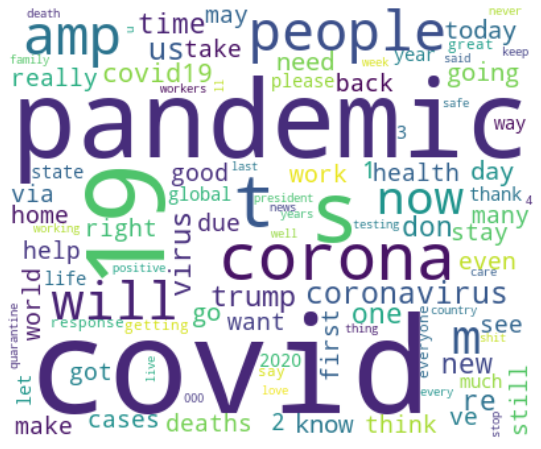

In [22]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

def gen_freq(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()

    #Print top 20 words
    word_freq = word_freq.drop(labels=STOPWORDS, errors='ignore')
    word_freq[:20]
    ### Remove Stop words
    
    return word_freq

#Generate word frequencies
word_freq = gen_freq(key_tweets.text.str)

#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


We could use conditions such as presence of two or more words together to classify the tweet as relevant or not. 

However, we can miss out on the context of the tweets while doing so. 


## 4 Using unsupervised algorithm to find out key topics of the tweet (Latent Sentiment Analysis)

Another approach that we could try out is using an unsupervised algorithm to extract topics out of the tweet. I will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is.

In [23]:
import nltk

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z0-9]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [26]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [27]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(key_tweets.text))

print(data_words[:1])

[['the', 'twitter', 'account', 'associated', 'with', 'that', 'youtube', 'channel', 'pandemic', 'is', 'interesting', 'it', 'certainly', 'slanted', 'towards', 'one', 'point', 'of', 'view', 'fear', 'this', 'will', 'turn', 'into', 'fight', 'over', 'who', 'gets', 'to', 'be', 'right', 'not', 'search', 'for', 'truth', 'that', 'in', 'itself', 'is', 'dangerous']]


In [28]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'twitter', 'account', 'associated', 'with', 'that', 'youtube_channel', 'pandemic', 'is', 'interesting', 'it', 'certainly', 'slanted', 'towards', 'one', 'point', 'of', 'view', 'fear', 'this', 'will', 'turn', 'into', 'fight', 'over', 'who', 'gets', 'to', 'be', 'right', 'not', 'search', 'for', 'truth', 'that', 'in', 'itself', 'is', 'dangerous']


In [29]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
nlp = spacy.load('en_core_web_sm')

In [31]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['twitter', 'associate', 'interesting', 'certainly', 'slant', 'point', 'view', 'fear', 'turn', 'fight', 'get', 'right', 'search', 'truth', 'dangerous']]


In [32]:
#Create the Dictionary and Corpus needed for Topic Modeling
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [33]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('associate', 1),
  ('certainly', 1),
  ('dangerous', 1),
  ('fear', 1),
  ('fight', 1),
  ('get', 1),
  ('interesting', 1),
  ('point', 1),
  ('right', 1),
  ('search', 1),
  ('slant', 1),
  ('truth', 1),
  ('turn', 1),
  ('twitter', 1),
  ('view', 1)]]

In [38]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [39]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"mask" + 0.042*"friend" + 0.040*"love" + 0.037*"response" + '
  '0.035*"hear" + 0.026*"old" + 0.025*"face" + 0.024*"ever" + 0.024*"person" + '
  '0.020*"fact"'),
 (1,
  '0.111*"covid" + 0.030*"day" + 0.028*"today" + 0.027*"new" + 0.026*"virus" + '
  '0.026*"due" + 0.026*"come" + 0.019*"week" + 0.018*"look" + 0.016*"give"'),
 (2,
  '0.075*"take" + 0.040*"want" + 0.039*"good" + 0.038*"still" + 0.034*"case" + '
  '0.030*"test" + 0.024*"show" + 0.023*"care" + 0.016*"health" + '
  '0.015*"patient"'),
 (3,
  '0.149*"pandemic" + 0.044*"get" + 0.043*"people" + 0.028*"make" + '
  '0.022*"amp" + 0.021*"see" + 0.018*"think" + 0.018*"help" + 0.015*"thing" + '
  '0.015*"even"'),
 (4,
  '0.041*"state" + 0.032*"tell" + 0.030*"put" + 0.029*"last" + 0.023*"end" + '
  '0.022*"wait" + 0.019*"ask" + 0.019*"mean" + 0.018*"middle" + 0.018*"kill"'),
 (5,
  '0.087*"death" + 0.058*"family" + 0.051*"stop" + 0.035*"lose" + '
  '0.032*"number" + 0.029*"report" + 0.028*"high" + 0.022*"order" + '
  '0

Interpreting this:

(9,
  '0.104*"corona" + 0.040*"right" + 0.040*"also" + 0.029*"job" + 0.026*"close" '
  '+ 0.020*"vaccine" + 0.019*"fight" + 0.018*"worker" + 0.016*"fuck" + '
  '0.015*"question"
  
It means the top 10 keywords that contribute to this topic are: corona, vaccine, worker. and so on and the weight of ‘corona’ on topic 9
is 0.104

The weights reflect how important a keyword is to that topic.

In [40]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.552386409883223

Coherence Score:  0.27876376399639713


In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\VoraH\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.425726  0.164703       1        1  24.852457
1      0.109651 -0.428223       2        1  15.794514
7     -0.020270 -0.044903       3        1  11.193940
2     -0.043280  0.038989       4        1   9.785028
8     -0.057701  0.034769       5        1   8.584357
6     -0.083108  0.054539       6        1   6.867822
9     -0.078505  0.046571       7        1   6.835457
4     -0.057191  0.021051       8        1   6.568173
0     -0.097641  0.059675       9        1   4.772956
5     -0.097682  0.052830      10        1   4.745297, topic_info=     Category          Freq            Term         Total  loglift  logprob
50    Default  60092.000000        pandemic  60092.000000  30.0000  30.0000
65    Default  28440.000000           covid  28440.000000  29.0000  29.0000
87    Default  18051.000000              go  18051.000000  28.0000  28.0000
469   Default  11575.000000          corona  11575.000000  27.0000  27.0000
478   Default  11958.000000            take  11958.000000  26.0000  26.0000
598   Default  11089.000000             say  11089.000000  25.0000  25.0000
452   Default  10115.000000            time  10115.000000  24.0000  24.0000
5     Default  17587.000000             get  17587.000000  23.0000  23.0000
89    Default  17293.000000          people  17293.000000  22.0000  22.0000
47    Default   6694.000000           death   6694.000000  21.0000  21.0000
176   Default   9259.000000            work   9259.000000  20.0000  20.0000
184   Default   9236.000000            know   9236.000000  19.0000  19.0000
235   Default   6619.000000            year   6619.000000  18.0000  18.0000
49    Default   7570.000000            need   7570.000000  17.0000  17.0000
59    Default  11231.000000            make  11231.000000  16.0000  16.0000
207   Default   6342.000000            want   6342.000000  15.0000  15.0000
266   Default   6271.000000            good   6271.000000  14.0000  14.0000
639   Default   7762.000000             day   7762.000000  13.0000  13.0000
34    Default   5726.000000           thank   5726.000000  12.0000  12.0000
144   Default   6035.000000           still   6035.000000  11.0000  11.0000
646   Default   4443.000000          family   4443.000000  10.0000  10.0000
475   Default   7256.000000           today   7256.000000   9.0000   9.0000
376   Default   6896.000000             new   6896.000000   8.0000   8.0000
54    Default   5454.000000            case   5454.000000   7.0000   7.0000
353   Default   6763.000000           virus   6763.000000   6.0000   6.0000
307   Default   6691.000000             due   6691.000000   5.0000   5.0000
225   Default   6595.000000            come   6595.000000   4.0000   4.0000
191   Default   8717.000000             amp   8717.000000   3.0000   3.0000
8     Default   4490.000000           right   4490.000000   2.0000   2.0000
396   Default   8621.000000             see   8621.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
47    Topic10   6693.394531           death   6694.372559   3.0479  -2.4431
646   Topic10   4442.858398          family   4443.836426   3.0478  -2.8530
1020  Topic10   3919.908936            stop   3920.887207   3.0478  -2.9782
992   Topic10   2714.500977            lose   2715.479248   3.0477  -3.3457
744   Topic10   2491.250244          number   2492.228516   3.0476  -3.4315
163   Topic10   2213.488770          report   2214.467041   3.0476  -3.5497
528   Topic10   2164.282715            high   2165.260986   3.0476  -3.5722
651   Topic10   1704.110596           order   1705.088745   3.0474  -3.8112
358   Topic10   1666.187012            news   1667.165161   3.0474  -3.8337
1721  Topic10   1661.017456            join   1661.995728   3.0474  -3.8368
647   Topic10   1421.518555            hand   1422.496826   3.0473  -3.9925
1542  Topic10   1244.485474         morni